# 1A.e - Enoncé 23 octobre 2018 (1)

Correction du premier énoncé de l'examen du 23 octobre 2018. L'énoncé propose une méthode pour renseigner les valeurs manquantes dans une base de deux variables.

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

On sait d'après les dernières questions qu'il faudra tout répéter plusieurs fois. On prend le soin d'écrire chaque question dans une fonction.

## Q1 - échantillon aléatoire

Générer un ensemble de $N=1000$ couples aléatoires $(X_i,Y_i)$ qui vérifient :

* $X_i$ suit une loi normale de variance 1.
* $Y_i = 2 X_i + \epsilon_i$ où $\epsilon_i$ suit une loi normale de variance 1.

In [2]:
import numpy.random as rnd
import numpy

def random_mat(N):
    mat = numpy.zeros((N, 2))
    mat[:, 0] = rnd.normal(size=(N,))
    mat[:, 1] = mat[:, 0] * 2 + rnd.normal(size=(N,))
    return mat

N = 1000
mat = random_mat(N)
mat[:5]

array([[-0.21542897, -1.02478399],
       [-0.89552004, -2.24733264],
       [-1.393163  , -5.40164738],
       [ 1.32997878,  2.70660631],
       [-1.20765567, -2.43301488]])

**Remarque 1 :** Un élève a retourné cette réponse, je vous laisse chercher pourquoi ce code produit deux variables tout-à-fait décorrélées.

```
def random_mat(N=1000):
    A = np.random.normal(0,1,(N,2))
    A[:,1] = 2*A[:,1] + np.random.normal(0,1,N)/10
    return A
```

Cela peut se vérifier en calculant la corrélation.

**Remarque 2 :** Un élève a généré le nuage $X + 2\epsilon$ ce qui produit un nuage de points dont les deux variable sont moins corrélées. Voir à la fin pour plus de détail.

## Q2 - matrice m1

On définit la matrice $M \in \mathbb{M}_{N,2}(\mathbb{R})$ définie par les deux vecteurs colonnes $(X_i)$ et $(Y_i)$. Choisir aléatoirement 20 valeurs dans cette matrice et les remplacer par ``numpy.nan``. On obtient la matrice $M_1$.

In [3]:
import random

def build_m1(mat, n=20):
    mat = mat.copy()
    positions = []
    while len(positions) < n:
        h = random.randint(0, mat.shape[0] * mat.shape[1] - 1)
        pos = h % mat.shape[0], h // mat.shape[0]
        if pos in positions:
            # La position est déjà tirée.
            continue
        positions.append(pos)
        mat[pos] = numpy.nan
    return mat, positions

m1, positions = build_m1(mat)
p = positions[0][0]
m1[max(p-2, 0):min(p+3, mat.shape[0])]

array([[ 0.26184685,  0.41751593],
       [-0.53354327,  0.34849608],
       [-1.96298222,         nan],
       [ 1.51815696,  1.58374784],
       [ 0.71569523,  3.12326482]])

**Remarque 1:** l'énoncé ne précisait pas s'il fallait choisir les valeurs aléatoires sur une ou deux colonnes, le faire sur une seule colonne est sans doute plus rapide et ne change rien aux conclusions des dernières questions.

**Remarque 2:** il ne faut pas oublier de copier la matrice ``mat.copy()``, dans le cas contraire, la fonction modifie la matrice originale. Ce n'est pas nécessairement un problème excepté pour les dernières questions qui requiert de garder cette matrice.

**Remarque 3:** l'énoncé ne précisait pas avec ou sans remise. L'implémentation précédente le fait sans remise.

## Q3 - moyenne

Calculer $\mathbb{E}{X} = \frac{1}{N}\sum_i^N X_i$ et $\mathbb{E}Y = \frac{1}{N}\sum_i^N Y_i$. Comme on ne tient pas compte des valeurs manquantes, les moyennes calculées se font avec moins de $N$ termes. Si on définit $V_x$ et $V_y$ l'ensemble des valeurs non manquantes, on veut calculer $\mathbb{E}{X} = \frac{\sum_{i \in V_x} X_i}{\sum_{i \in V_x} 1}$ et $\mathbb{E}Y = \frac{\sum_{i \in V_y} Y_i}{\sum_{i \in V_y} 1}$.

In [4]:
def mean_no_nan(mat):
    res = []
    for i in range(mat.shape[1]):
        ex = numpy.mean(mat[~numpy.isnan(mat[:, i]), i])
        res.append(ex)
    return numpy.array(res)

mean_no_nan(m1)

array([0.05543522, 0.0564421 ])

**Remarque 1 :** il était encore plus simple d'utiliser la fonction [nanmean](https://docs.scipy.org/doc/numpy/reference/generated/numpy.nanmean.html#numpy.nanmean).

**Remarque 2 :** Il fallait diviser par le nombre de valeurs non nulles et non le nombre de lignes de la matrice.

## Q4 - matrice m2

Remplacer les valeurs manquantes de la matrice $M_1$ par la moyenne de leurs colonnes respectives. On obtient la matrice $M_2$.

In [5]:
def build_m2(mat):
    means = mean_no_nan(mat)
    m2 = mat.copy()
    for i in range(len(means)):
        m2[numpy.isnan(m2[:, i]), i] = means[i]
    return m2

m2 = build_m2(m1)
m2[max(p-2, 0):min(p+3, mat.shape[0])]

array([[ 0.26184685,  0.41751593],
       [-0.53354327,  0.34849608],
       [-1.96298222,  0.0564421 ],
       [ 1.51815696,  1.58374784],
       [ 0.71569523,  3.12326482]])

## Q5 - matrice m3

On trie la matrice $M_1$ selon la première colonne. On remplace chaque $y$ manquant par la moyenne des deux valeurs qui l'entourent. On recommence avec les $x$ manquant. On obtient la matrice $M_3$.

In [6]:
def fill_column(mat, col):
    nlin, ncol = mat.shape
    order = numpy.argsort(mat[:, 1-col])
    reverse_order = numpy.arange(0, nlin)
    for i, v in enumerate(order):
        reverse_order[v] = i
    bmat = mat[order, :]
    last = None
    replace = []
    for i in range(0, nlin):
        if numpy.isnan(bmat[i, col]):
            replace.append(i)
        else:
            if replace:
                current = bmat[i, col]
                if last is None:
                    for r in replace:
                        bmat[r, col] = current
                else:
                    for k, r in enumerate(replace):
                        bmat[r, col] = last + (current - last) * float(k + 1) / (len(replace) + 1)
            last = bmat[i, col]
            replace = []
            
    if len(replace) > 0:
        # Il reste des valeurs manquantes à la fin.
        for r in replace:
            bmat[r, col] = last        
    
    return bmat[reverse_order, :]

def build_m3(mat):
    m3 = mat.copy()
    for i in range(0, mat.shape[1]):
        m3 = fill_column(m3, i)
    return m3

m3 = build_m3(m1)
m3[max(p-2, 0):min(p+3, mat.shape[0])]

array([[ 0.26184685,  0.41751593],
       [-0.53354327,  0.34849608],
       [-1.96298222, -3.18717541],
       [ 1.51815696,  1.58374784],
       [ 0.71569523,  3.12326482]])

On vérifie avec *pandas* que tout s'est bien passe.

In [7]:
from pandas import DataFrame
df = DataFrame(m3)
df[df.iloc[:, 0].isnull()]

,0,1


In [8]:
df[df.iloc[:, 1].isnull()]

,0,1


Tout va bien.

## Q6 - norme

On a deux méthodes pour compléter les valeurs manquantes, quelle est la meilleure ? Il faut vérifier numériquement en comparant $\parallel M-M_2 \parallel^2$ et $\parallel M-M_3 \parallel^2$.

In [9]:
def distance(m1, m2):
    d = m1.ravel() - m2.ravel()
    return d @ d

d2 = distance(mat, m2)
d3 = distance(mat, m3)
d2, d3

(115.16303767944946, 12.990990757306854)

**Remarque :** Un élève a écrit avoir trouvé ces résultats :

```
Calcul_norme(M - M2) = 56,57   
Calcul_norme(M- M3) = 0.0 
```

Un résultat nul doit automatiquement mettre la puce à l'oreille puisque car il est hautement improbable que la matrice ``M`` et la matrice ``M3`` soit identique à moins que la matrice ``M`` n'ait été modifiée. On en déduit que le premier nombre est en fait la distance ``Calcul_norme(M2 - M3)``.

## Q7 - répétition

Une experience réussie ne veut pas dire que cela fonctionne. Recommencer 10 fois en changeant le nuages de points et les valeurs manquantes ajoutées.

In [10]:
def repetition(N=1000, n=20, nb=10):
    res = []
    for i in range(nb):
        mat = random_mat(N)
        m1, _ = build_m1(mat, n)
        m2 = build_m2(m1)
        m3 = build_m3(m1)        
        d2, d3 = distance(mat, m2), distance(mat, m3)
        res.append((d2, d3))
    return numpy.array(res)

repetition()

array([[ 49.25531314,  19.070392  ],
       [ 76.57432808,  18.73422968],
       [ 43.43834865,  15.07553875],
       [ 50.49648148,  10.11340377],
       [116.28344822,  23.90363643],
       [ 52.90465816,  14.88595361],
       [117.28824424,  28.05673836],
       [ 83.37972659,  14.28703801],
       [ 48.97835736,  13.49136146],
       [ 99.70723528,  27.34848088]])

## Q8 - plus de valeurs manquantes

Et si on augmente le nombre de valeurs manquantes, l'écart se creuse-t-il ou se réduit -il ? Montrez-le numériquement.

In [11]:
diff = []
ns = []
for n in range(10, 1000, 10):
    res = repetition(n=n, nb=10)
    diff.append(res.mean(axis=0) / n)
    ns.append(n)
diff = numpy.array(diff)
diff[:5]

array([[3.10112512, 1.1306255 ],
       [2.94022724, 0.91916954],
       [2.96721215, 1.14121786],
       [3.35629971, 0.99870181],
       [3.48138722, 1.00467304]])

In [12]:
%matplotlib inline

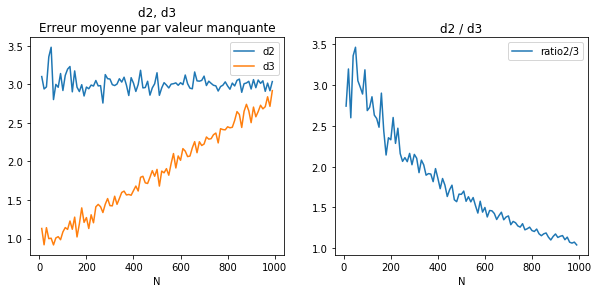

In [13]:
import pandas
df = pandas.DataFrame(diff, columns=["d2", "d3"])
df['N'] = ns
df = df.set_index('N')
df["ratio2/3"] = df["d2"] / df["d3"]

import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
df[["d2", "d3"]].plot(ax=ax[0])
df[["ratio2/3"]].plot(ax=ax[1])
ax[0].set_title("d2, d3\nErreur moyenne par valeur manquante")
ax[1].set_title("d2 / d3");

Plus il y a de valeurs manquantes, plus le ratio tend vers 1 car il y a moins d'informations pour compléter les valeurs manquantes autrement que par la moyenne. Il y a aussi plus souvent des couples de valeurs manquantes qui ne peuvent être remplacés que par la moyenne.

## Q9 - 1 valeur manquante ?

S'il n'y qu'une valeur manquante, peut-on sans changer le résultat se passer de tri pour avoir un coût linéaire ?

Si la valeur manquante est dans la colonne 0, il suffit de chercher l'intervalle le plus petit qui encadre la valeur sur la colonne 1 puis de faire la moyenne des valeurs sur les deux valeurs sur la colonne 0.

In [14]:
def build_m3_just1(mat):
    for i in range(0, mat.shape[0]):
        if numpy.isnan(mat[i, 0]):
            pos = i, 0
            col = 1
            value = mat[i, 1]
            break
        if numpy.isnan(mat[i, 1]):
            pos = i, 1
            col = 0
            value = mat[i, 0]
            break
    
    imin, imax = None, None
    for i in range(0, mat.shape[0]):
        if i == pos[0]:
            continue
        if imin is None or mat[imin, col] < mat[i, col] <= value:
            imin = i
        if imax is None or mat[imax, col] > mat[i, col] >= value:
            imax = i
    mat = mat.copy()
    mat[pos] = (mat[imin, col] + mat[imax, col]) / 2
    return mat

mat = numpy.array([[10, 11],
                   [9, 10],
                   [8, numpy.nan],
                   [7, 9],
                   [6, 8]])
build_m3_just1(mat)

array([[10. , 11. ],
       [ 9. , 10. ],
       [ 8. ,  9.5],
       [ 7. ,  9. ],
       [ 6. ,  8. ]])

Un élève a suggéré le tri dichotomique qui n'est évidemment pas une option puisque la dichotomie nécessite qu'une colonne soit triée au préalable et c'est justement ce qu'on cherche à éviter.

## Q10 - plus de deux colonnes ?

Pour cette question, vous avez le choix entre implémenter la solution que vous proposez à la question précédente ou proposer une façon d'étendre la méthode dans le cas où il y a 3 dimensions.

Dans le cas de notre matrice, on utilise l'autre colonne pour ordonner les lignes. Avec plusieurs colonnes, il faudrait choisir la colonne la plus corrélée.

In [15]:
def random_mat(N, alpha):
    mat = numpy.zeros((N, 2))
    mat[:, 0] = rnd.normal(size=(N,))
    mat[:, 1] = mat[:, 0] * alpha + rnd.normal(size=(N,))
    return mat

rows = []
for alpha in [0.01 * h for h in range(0, 500)]:
    m = random_mat(1000, alpha)
    m1, _ = build_m1(m, 20)
    m2 = build_m2(m1)
    m3 = build_m3(m1)
    d2, d3 = distance(m, m2), distance(m, m3)
    cc = numpy.corrcoef(m.T)[0, 1]
    rows.append(dict(corr=cc, d2=d2**0.5, d3=d3**0.5))

df = pandas.DataFrame(rows)
df.tail()

,corr,d2,d3
495,0.979253,19.308262,4.616462
496,0.980323,21.790158,2.667422
497,0.977415,15.050925,2.430873
498,0.980746,21.885168,3.995820
499,0.978955,5.935248,4.137125


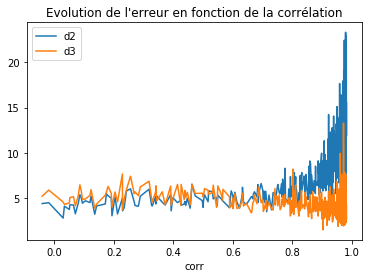

In [16]:
ax = df.sort_values("corr").plot(x="corr", y=["d2", "d3"])
ax.set_title("Evolution de l'erreur en fonction de la corrélation");

On voit que la second méthode est meilleure si la corrélation est supérieur à 0.7. Plutôt moins bonne avant.